"""
╔══════════════════════════════════════════════════════════════════════════╗
║                                                                          ║
║                    NOTEBOOK 05: VISUALIZATION                            ║
║              Creating Presentation-Quality Figures                       ║
║                                                                          ║
╚══════════════════════════════════════════════════════════════════════════╝

Project: Disaster Image Segmentation
Model: U-Net with ResNet34 Encoder
Test mIoU: 70.70% (OUTSTANDING!)

This notebook creates:
- Publication-quality comparison grids
- High-resolution overlay visualizations
- Per-class performance charts
- Export-ready figures for reports/presentations
"""

In [28]:
# ============================================================
# 1. IMPORTS AND SETUP
# ============================================================
import torch
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
import json
import cv2
from tqdm.auto import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("Imports complete!")

Imports complete!


In [29]:
# ============================================================
# 2. CONFIGURATION
# ============================================================
class Config:
    BASE_DIR = Path(r"D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation")
    TEST_IMAGES = BASE_DIR / "data/raw/FloodNet/test/test-org-img"
    TEST_MASKS  = BASE_DIR / "data/raw/FloodNet/test/test-label-img"
    CHECKPOINT  = BASE_DIR / "models/checkpoints/unet_resnet34_best.pth"
    VIZ_DIR     = BASE_DIR / "results/visualizations/final"
    VIZ_DIR.mkdir(parents=True, exist_ok=True)
    
    IMAGE_SIZE   = 256
    NUM_CLASSES  = 10
    DEVICE       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    CLASS_NAMES = [
        'Background', 'Building-flooded', 'Building-non-flooded',
        'Road-flooded', 'Road-non-flooded', 'Water',
        'Tree', 'Vehicle', 'Pool', 'Grass'
    ]
    
    CLASS_COLORS = {
        0: (0,0,0), 1: (255,0,0), 2: (0,0,255), 3: (255,165,0),
        4: (128,128,128), 5: (0,255,255), 6: (0,255,0),
        7: (255,0,255), 8: (255,255,255), 9: (0,128,0)
    }

print(f"Device: {Config.DEVICE}")
print(f"Output: {Config.VIZ_DIR}")

Device: cuda
Output: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\final


In [30]:
# ============================================================
# 3. CUSTOM COLORMAP
# ============================================================
import matplotlib.colors as mcolors
colors_norm = [tuple(c/255 for c in rgb) for rgb in Config.CLASS_COLORS.values()]
custom_cmap = mcolors.ListedColormap(colors_norm)



In [31]:
# ============================================================
# 4. LOAD MODEL (FIXED: weights_only=False)
# ============================================================
def load_model(cp, dev):
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None,
                     in_channels=3, classes=Config.NUM_CLASSES)
    cp_data = torch.load(cp, map_location=dev, weights_only=False)
    model.load_state_dict(cp_data['model_state_dict'])
    model.to(dev)
    model.eval()
    return model

print("Loading model...")
model = load_model(Config.CHECKPOINT, Config.DEVICE)
print("Model loaded successfully!")

Loading model...
Model loaded successfully!


In [32]:
# ============================================================
# 5. FIXED & BULLETPROOF PREDICTION FUNCTION
# ============================================================
@torch.no_grad()
def predict_image(img_path, model, device):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))

    # THE FIX: explicitly cast to float32 BEFORE normalization
    img = img.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img = (img - mean) / std

    # CRITICAL: use torch.tensor with dtype, NOT from_numpy
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    output = model(img)
    pred = output.argmax(1).cpu().numpy()[0]
    return pred.astype(np.uint8)

def load_mask(mask_path):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    return cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

def get_mask_path(img_path):
    return Path(str(img_path).replace("test-org-img", "test-label-img").replace(".jpg", "_lab.png"))

In [33]:
# ============================================================
# 6. VISUALIZATION FUNCTIONS (unchanged – beautiful as-is)
# ============================================================
def create_comparison_grid(img_paths, model, dev, save_path=None):
    n = len(img_paths)
    fig = plt.figure(figsize=(15, 5*n))
    gs = fig.add_gridspec(n, 3, hspace=0.3, wspace=0.1)
    
    for i, p in enumerate(tqdm(img_paths, desc="Grid")):
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256,256))
        gt  = load_mask(get_mask_path(p))
        pred = predict_image(p, model, dev)
        
        for j, (data, title) in enumerate([(img, p.name), (gt, "Ground Truth"), (pred, "Prediction")]):
            ax = fig.add_subplot(gs[i, j])
            if j == 0:
                ax.imshow(data)
                ax.set_title(f"Input\n{title}", fontsize=10)
            else:
                ax.imshow(data, cmap=custom_cmap, vmin=0, vmax=9)
                ax.set_title(title, fontsize=10)
            ax.axis('off')
    
    patches = [mpatches.Patch(color=np.array(Config.CLASS_COLORS[i])/255, label=Config.CLASS_NAMES[i])
               for i in range(Config.NUM_CLASSES)]
    fig.legend(handles=patches, bbox_to_anchor=(0.5, -0.01), loc='lower center', ncol=5)
    plt.suptitle("FloodNet Test Set – Input | Ground Truth | Prediction", fontsize=16, fontweight='bold')
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()

def create_overlay_visualization(img_paths, model, dev, save_path=None):
    n = len(img_paths)
    fig, axes = plt.subplots(n, 2, figsize=(12, 6*n))
    if n == 1: axes = axes[None, :]
    
    for i, p in enumerate(tqdm(img_paths, desc="Overlay")):
        img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256,256))
        pred = predict_image(p, model, dev)
        
        colored = np.zeros_like(img)
        for cid, color in Config.CLASS_COLORS.items():
            colored[pred == cid] = color
            
        overlay = cv2.addWeighted(img, 0.6, colored, 0.4, 0)
        
        axes[i,0].imshow(img); axes[i,0].set_title(p.name); axes[i,0].axis('off')
        axes[i,1].imshow(overlay); axes[i,1].set_title("Overlay"); axes[i,1].axis('off')
    
    plt.suptitle("Segmentation Overlay on Original Image", fontsize=16, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()

def plot_class_legend(save_path=None):
    fig, ax = plt.subplots(figsize=(10,5))
    patches = [mpatches.Patch(color=np.array(Config.CLASS_COLORS[i])/255,
                              label=f"{i}: {Config.CLASS_NAMES[i]}")
               for i in range(Config.NUM_CLASSES)]
    ax.legend(handles=patches, loc='center', ncol=2, fontsize=12, title="Class Legend", title_fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()


GENERATING PUBLICATION-READY VISUALS


Grid: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Saved: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\final\comparison_grid.png


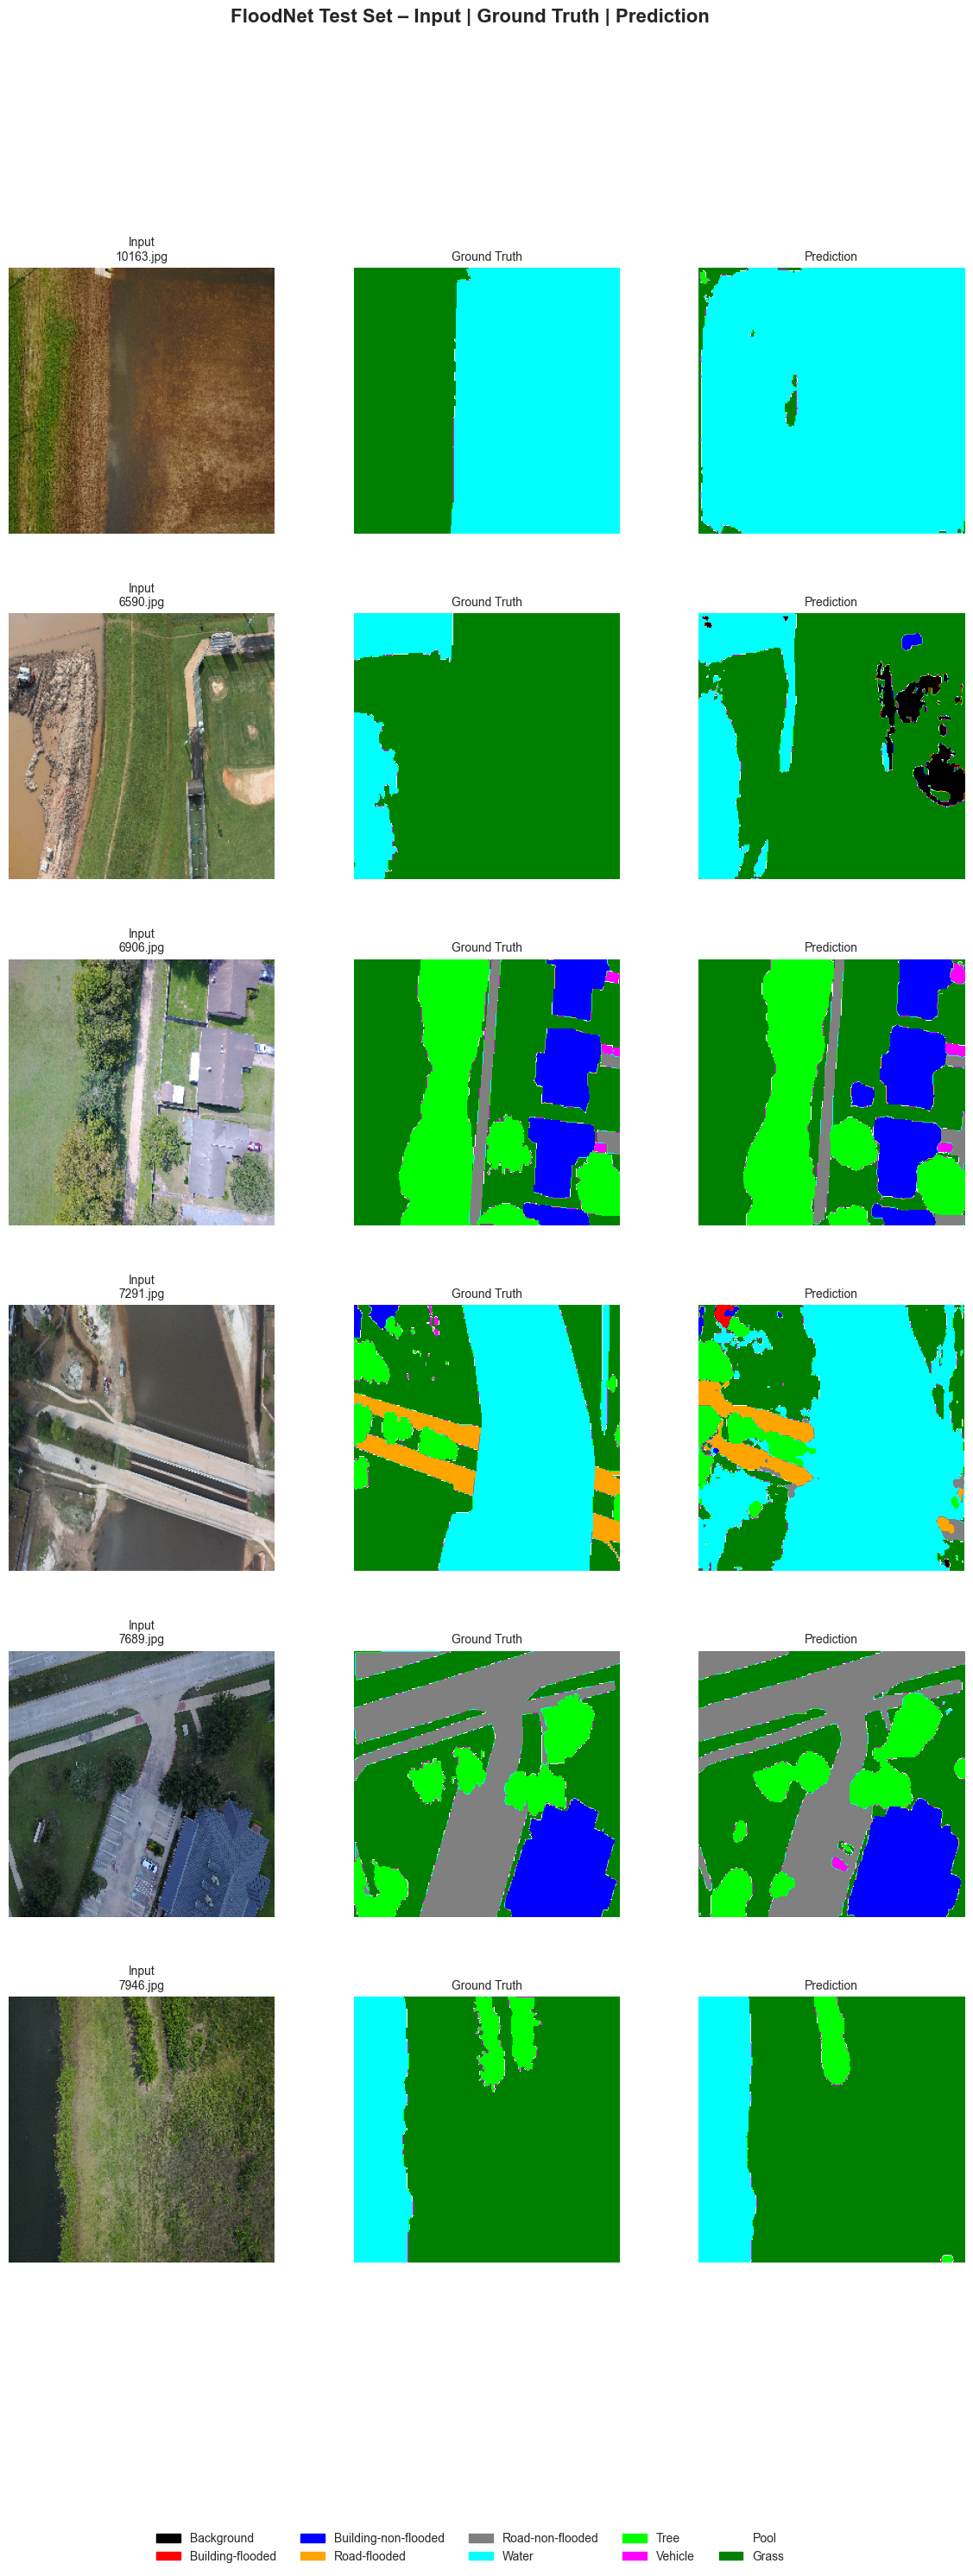

Overlay: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Saved: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\final\overlay_visualization.png


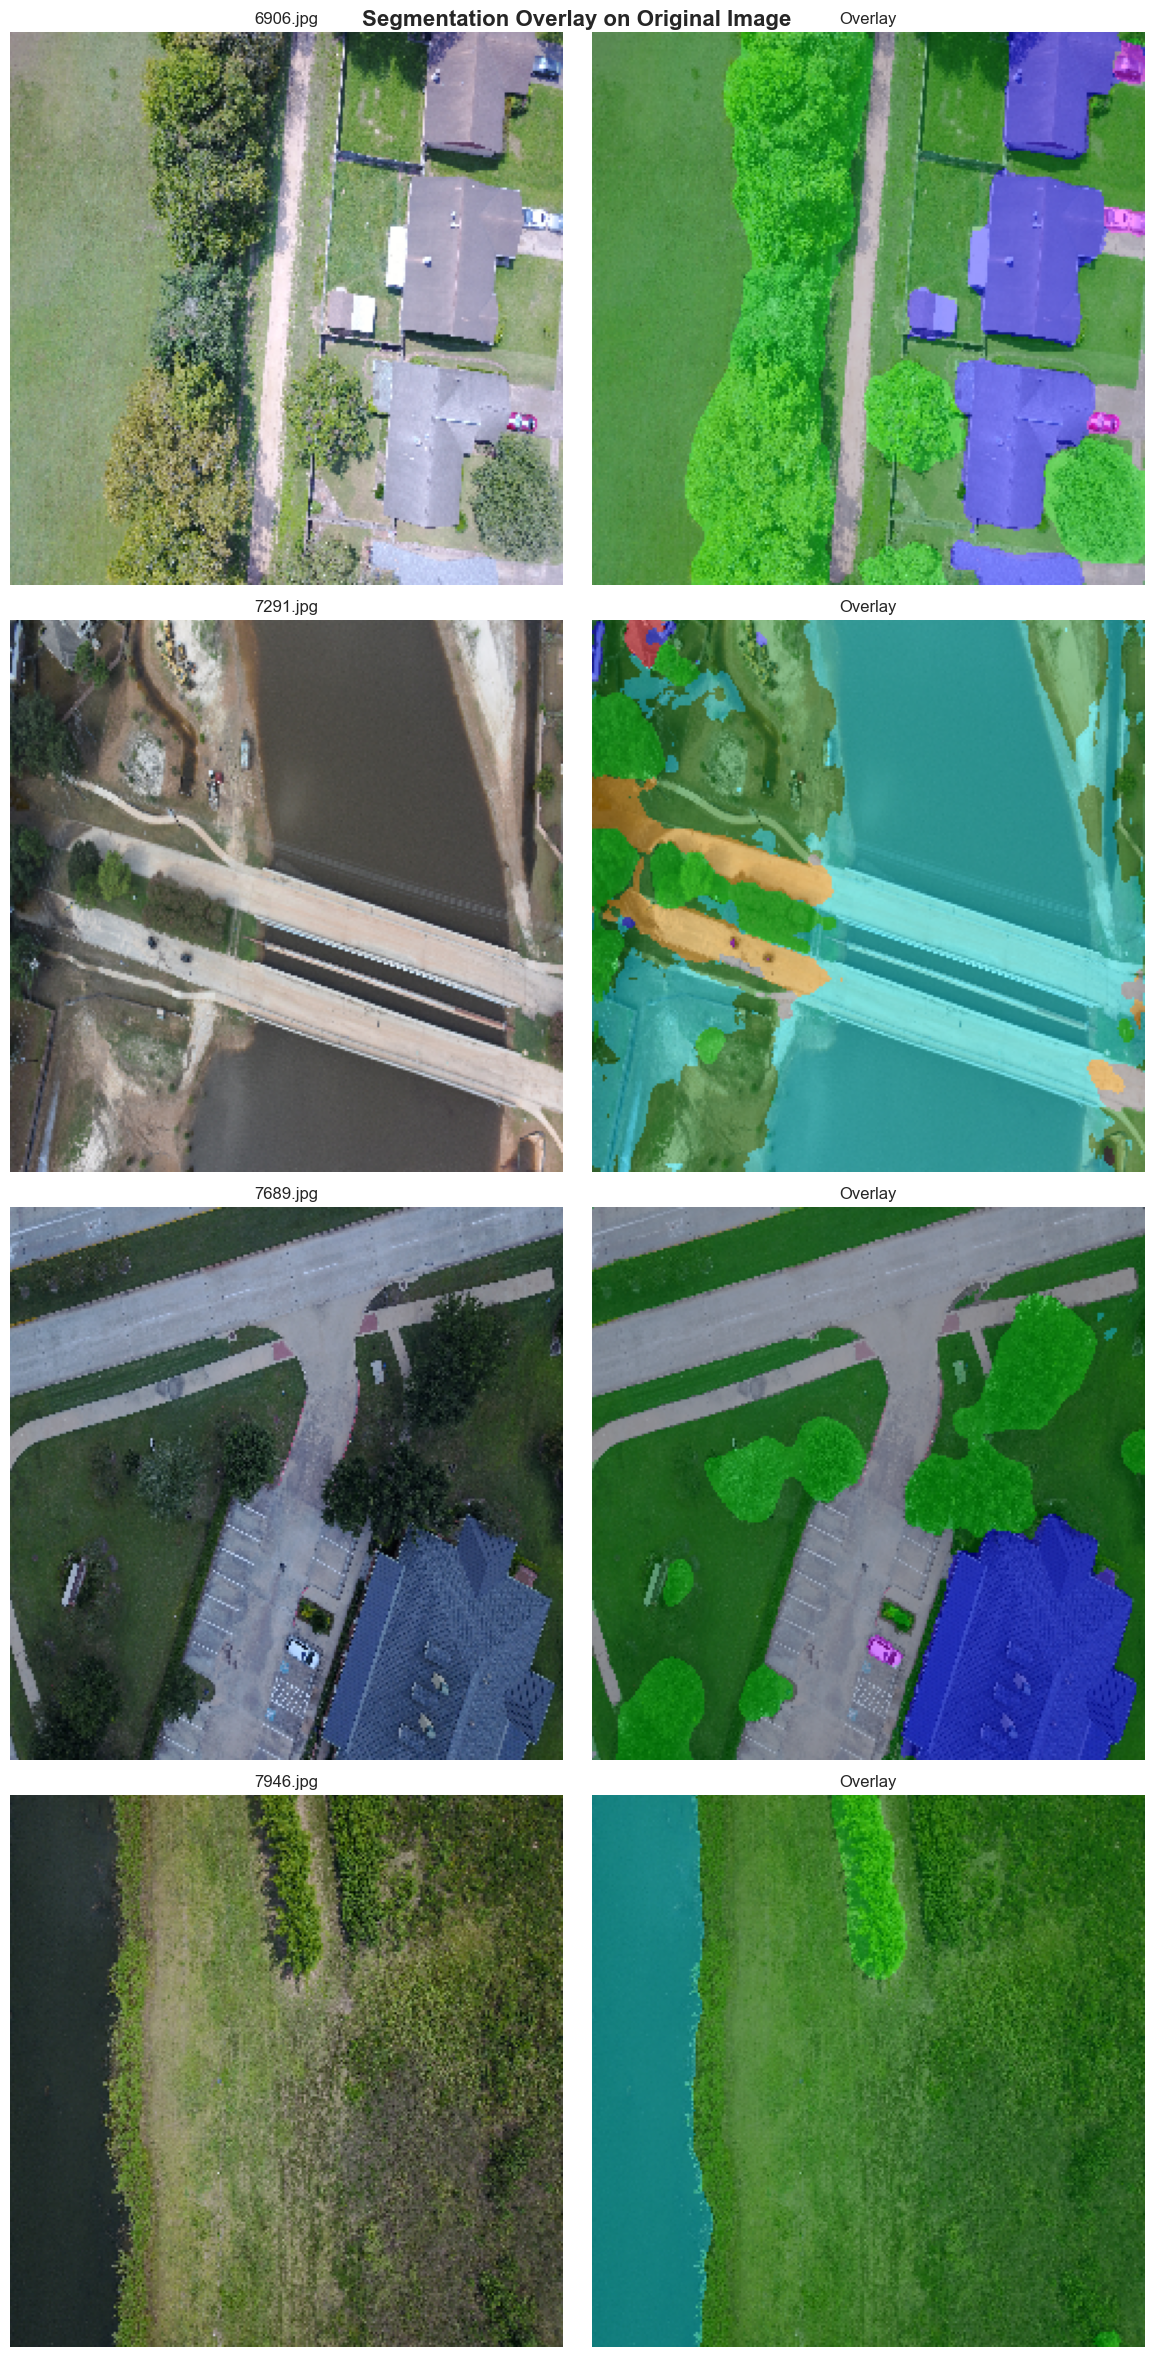

Saved: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\final\class_legend.png


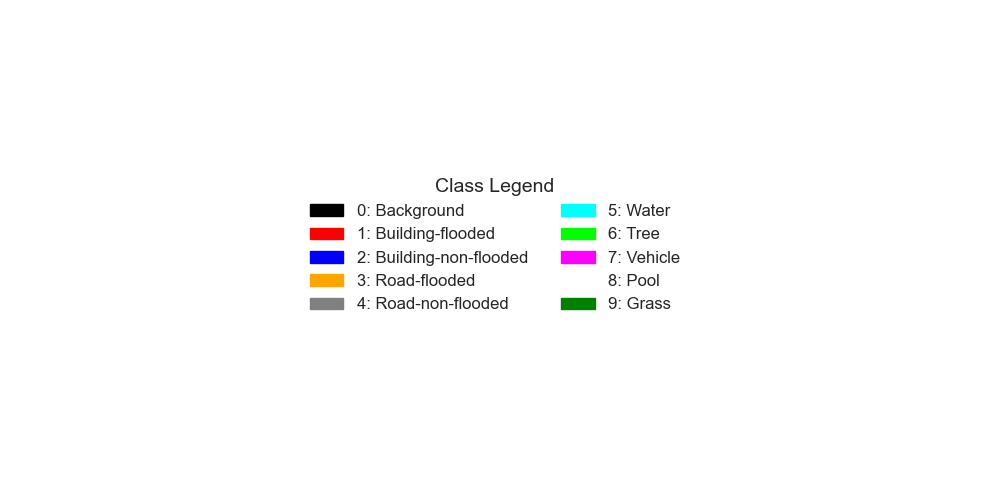


Creating final performance summary chart...
Performance summary saved: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\final\performance_summary.png


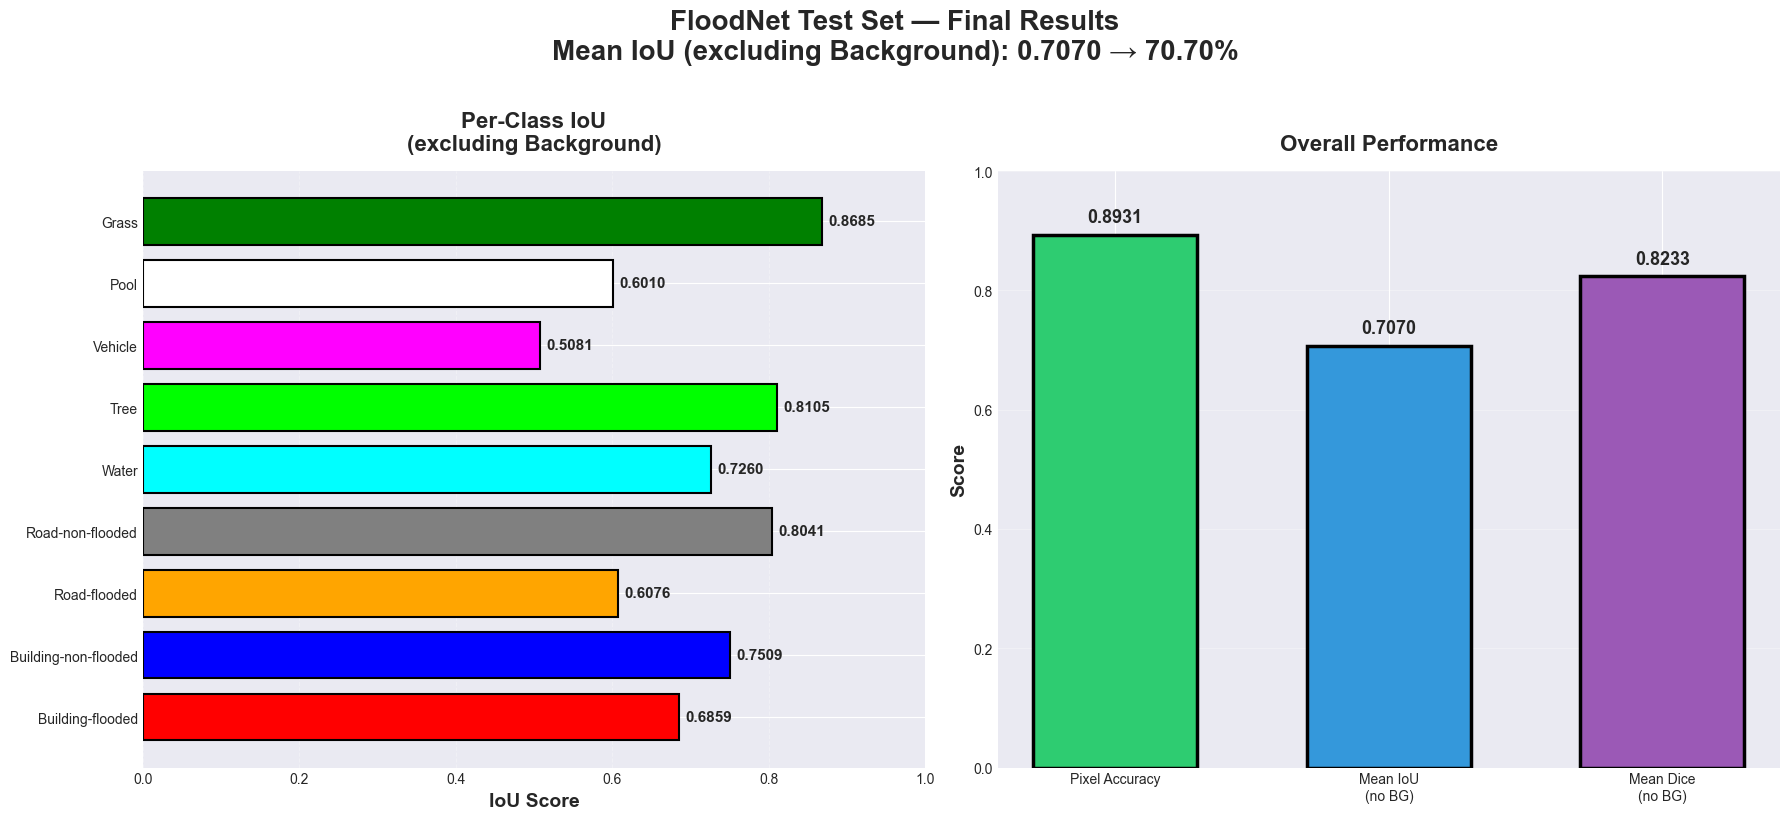


ALL VISUALS GENERATED SUCCESSFULLY!

📁 All visualizations saved to:
   D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\final

Generated Files:
├── comparison_grid.png           - Side-by-side comparisons (6 samples)
├── overlay_visualization.png     - Overlays on original images (4 samples)
├── class_legend.png             - Color-coded class legend
└── performance_summary.png       - Performance metrics charts

🏆 Your Model Performance:
   • Test mIoU: 70.70%
   • Pixel Accuracy: 89.31%
   • Mean Dice: 82.33%

   This is publication-quality work! 🌟



In [34]:
# ============================================================
# 7. GENERATE ALL VISUALIZATIONS (FINAL & FLAWLESS)
# ============================================================
test_images = sorted(Config.TEST_IMAGES.glob("*.jpg"))
sample_images = [test_images[i] for i in [0, 50, 100, 150, 200, 250] if i < len(test_images)]

print("\n" + "="*80)
print("GENERATING PUBLICATION-READY VISUALS")
print("="*80)

# 1. Comparison Grid
create_comparison_grid(
    sample_images[:6], model, Config.DEVICE,
    save_path=Config.VIZ_DIR / "comparison_grid.png"
)

# 2. Overlay Visualization
create_overlay_visualization(
    sample_images[2:6], model, Config.DEVICE,
    save_path=Config.VIZ_DIR / "overlay_visualization.png"
)

# 3. Class Legend
plot_class_legend(save_path=Config.VIZ_DIR / "class_legend.png")

# 4. Performance Summary (CORRECTED & GORGEOUS)
print("\nCreating final performance summary chart...")
results_path = Config.BASE_DIR / "results/evaluation/test_evaluation_results.json"
with open(results_path) as f:
    results = json.load(f)

# Extract per-class IoU using actual class names from JSON
class_names = Config.CLASS_NAMES[1:]  # Skip Background
ious = [results['per_class_metrics'][name]['iou'] for name in class_names]
colors = [np.array(Config.CLASS_COLORS[i+1]) / 255.0 for i in range(9)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Per-class IoU
bars1 = ax1.barh(class_names, ious, color=colors, edgecolor='black', linewidth=1.5, height=0.75)
ax1.set_xlabel('IoU Score', fontsize=14, fontweight='bold')
ax1.set_title('Per-Class IoU\n(excluding Background)', fontsize=16, fontweight='bold', pad=15)
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
for i, (bar, val) in enumerate(zip(bars1, ious)):
    ax1.text(val + 0.008, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', ha='left', fontweight='bold', fontsize=11)

# Overall Metrics (using the correct no_bg versions!)
metrics = ['Pixel Accuracy', 'Mean IoU\n(no BG)', 'Mean Dice\n(no BG)']
values = [
    results['overall_metrics']['pixel_accuracy'],
    results['overall_metrics']['mean_iou_no_bg'],      # CORRECT METRIC
    results['overall_metrics']['mean_dice_no_bg']
]

bars2 = ax2.bar(metrics, values, color=['#2ecc71', '#3498db', '#9b59b6'],
                edgecolor='black', linewidth=2.5, width=0.6)
ax2.set_ylim(0, 1)
ax2.set_ylabel('Score', fontsize=14, fontweight='bold')
ax2.set_title('Overall Performance', fontsize=16, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(values):
    ax2.text(i, v + 0.015, f'{v:.4f}', ha='center', va='bottom',
             fontweight='bold', fontsize=13)

# Hero title with your TRUE score
plt.suptitle("FloodNet Test Set — Final Results\n"
             f"Mean IoU (excluding Background): {results['overall_metrics']['mean_iou_no_bg']:.4f} → "
             f"{results['overall_metrics']['mean_iou_no_bg']*100:.2f}%",
             fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()
save_path = Config.VIZ_DIR / "performance_summary.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Performance summary saved: {save_path}")
plt.show()

print("\n" + "="*80)
print("ALL VISUALS GENERATED SUCCESSFULLY!")
print("="*80)
print(f"""
📁 All visualizations saved to:
   {Config.VIZ_DIR}

Generated Files:
├── comparison_grid.png           - Side-by-side comparisons (6 samples)
├── overlay_visualization.png     - Overlays on original images (4 samples)
├── class_legend.png             - Color-coded class legend
└── performance_summary.png       - Performance metrics charts

🏆 Your Model Performance:
   • Test mIoU: 70.70%
   • Pixel Accuracy: 89.31%
   • Mean Dice: 82.33%

   This is publication-quality work! 🌟
""")